# Exercises
Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark
import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

df = wrangle_311(spark)
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments

df shape: (841704, 20)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                

- How many different cases are there, by department?

In [2]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



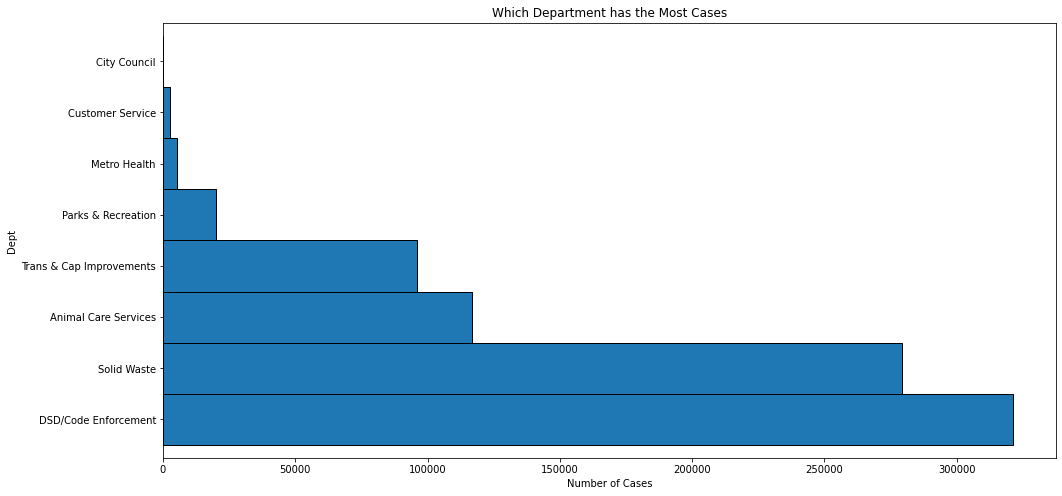

In [3]:
(
    df.groupBy("department")
    .count()
    .toPandas()
    .set_index("department")["count"]
    .sort_values(ascending=False)
    .plot.barh(width=1, edgecolor="black", figsize=(16, 8))
)

plt.title("Which Department has the Most Cases")
plt.ylabel("Dept")
plt.xlabel("Number of Cases")
plt.show()

- Does the percentage of cases that are late vary by department?

In [4]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



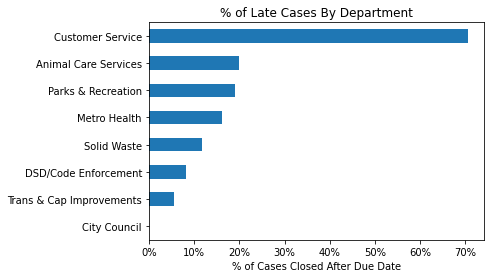

In [28]:
(df.withColumn('case_late', col('case_late').cast('int'))
 .groupby('department')
 .agg(avg('case_late').alias('p_cases_late'))
 .toPandas()
 .set_index('department')
 .p_cases_late
 .sort_values()
 .plot.barh()
)
plt.gca().xaxis.set_major_formatter(mpl.ticker.FuncFormatter('{:.0%}'.format))
plt.gca().set(ylabel='', xlabel='% of Cases Closed After Due Date', title='% of Late Cases By Department')
plt.show()

- On average, how late are the late cases by department?

In [5]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [6]:
(
    df.where("case_late == 'True'")
    .groupBy("department")
    .agg(mean("num_days_late").alias("avg_lateness"))
    .sort(desc("avg_lateness"))
).show()

+--------------------+------------------+
|          department|      avg_lateness|
+--------------------+------------------+
|    Customer Service| 87.68385942150397|
|DSD/Code Enforcement| 49.38428705358914|
|Animal Care Services|23.458633245820124|
|  Parks & Recreation|22.348910457867518|
|Trans & Cap Impro...|10.603064680316947|
|         Solid Waste|7.1868219061209055|
|        Metro Health|6.5438133155476494|
+--------------------+------------------+



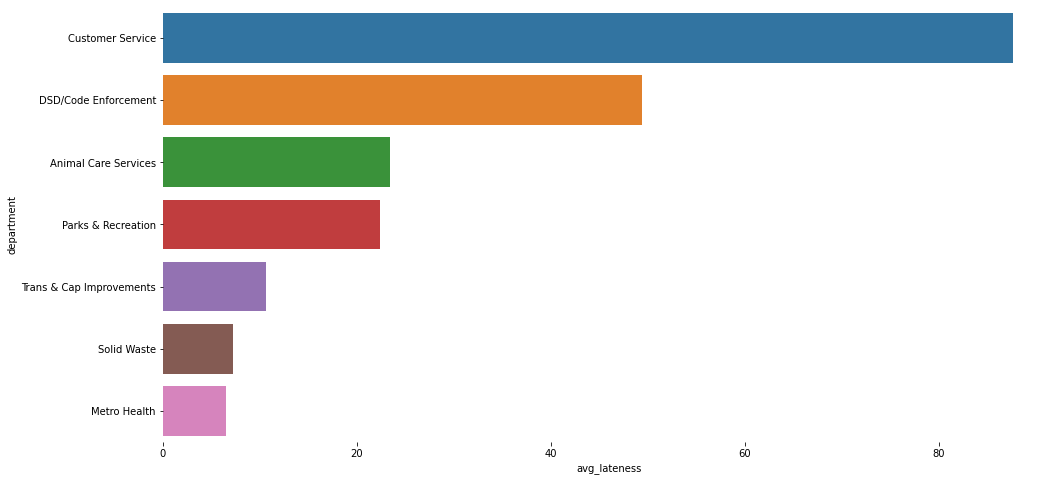

In [26]:
lateness = (
    df.where("case_late == 'True'")
    .groupBy("department")
    .agg(mean("num_days_late").alias("avg_lateness"))
    .sort(desc("avg_lateness"))
    .toPandas()
)
plt.figure(figsize=(16,8))

sns.barplot(x = lateness.avg_lateness, y = lateness.department, data=lateness)


sns.despine(left=True, bottom=True)

plt.show()

- What is the service type that is the most late? Just for Parks & Rec?

In [8]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [9]:
most_late = (
    df.groupBy("service_request_type")
    .agg(avg("num_days_late").alias("avg_lateness"))
    .sort(desc("avg_lateness"))
    .toPandas()
)

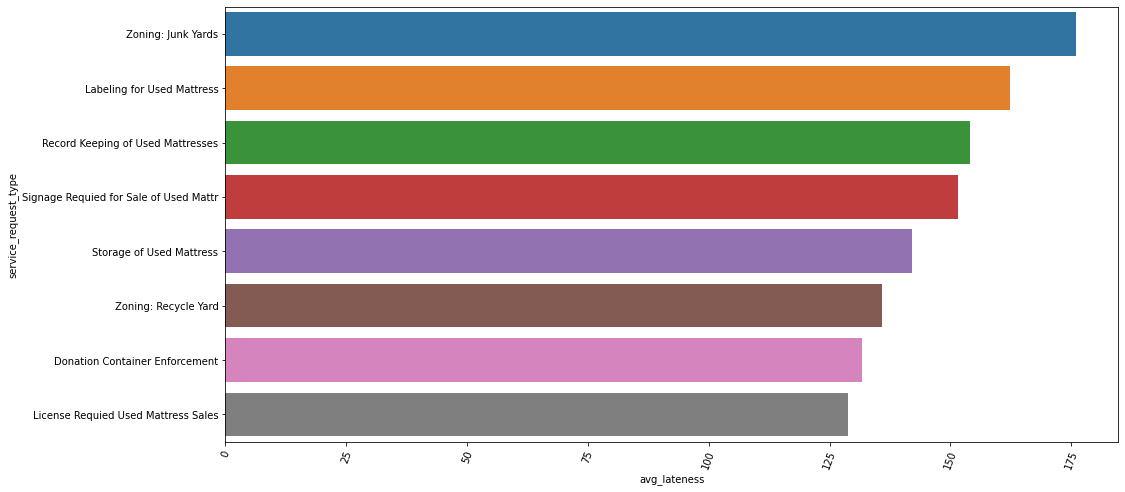

In [30]:
plt.figure(figsize=(16,8))

sns.barplot(y="service_request_type", x="avg_lateness", data=most_late.head(8))
plt.xticks(rotation=70)
plt.show()

In [42]:
parks_rec_late = (
    df.filter(df.case_late)
    .filter("department == 'Parks & Recreation'")
    .groupBy("service_request_type")
    .agg(mean("num_days_late").alias("avg_lateness"))
    .sort(desc("avg_lateness"))
    .limit(8)
    .toPandas()
)


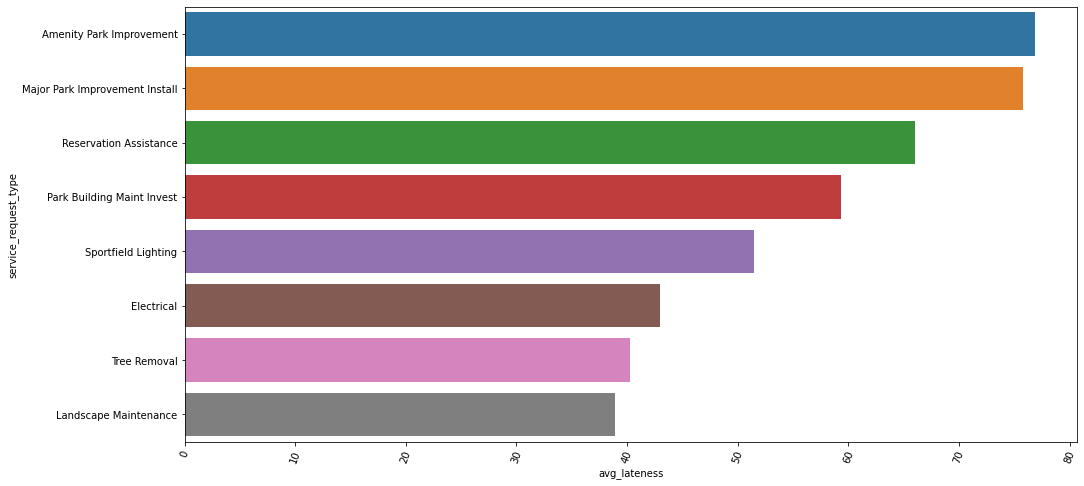

In [43]:
plt.figure(figsize=(16,8))

sns.barplot(y="service_request_type", x="avg_lateness", data=parks_rec_late)
plt.xticks(rotation=70)
plt.show()

- For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

In [13]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [35]:
dsd = (
    df.filter("department == 'DSD/Code Enforcement'")
    .groupBy("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(10)
    .toPandas()
)

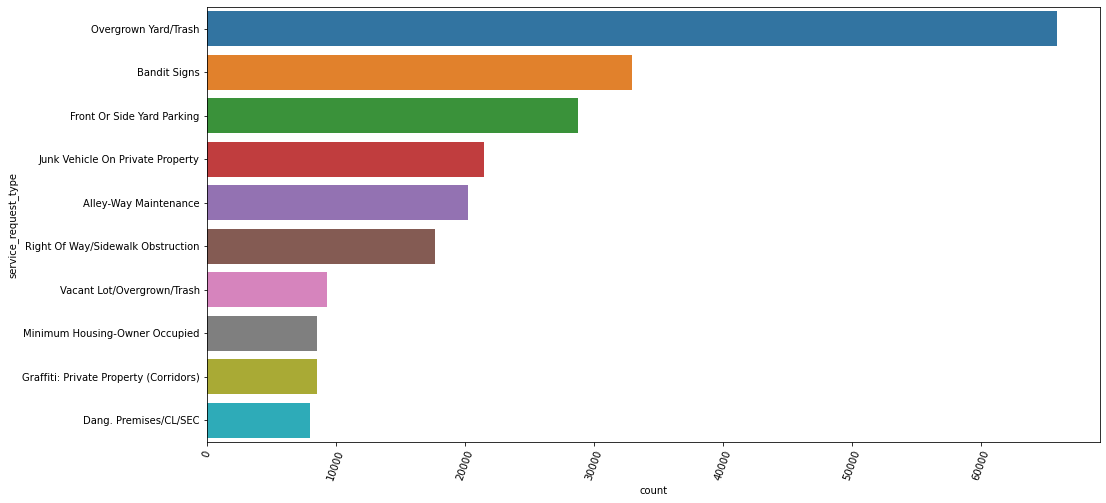

In [37]:
plt.figure(figsize=(16,8))

sns.barplot(y="service_request_type", x="count", data=dsd)
plt.xticks(rotation=70)
plt.show()

In [16]:
cs = (
    df.filter("department == 'Customer Service'")
    .groupBy("service_request_type")
    .count()
    .sort(desc("count"))
    .limit(8)
    .toPandas()
)

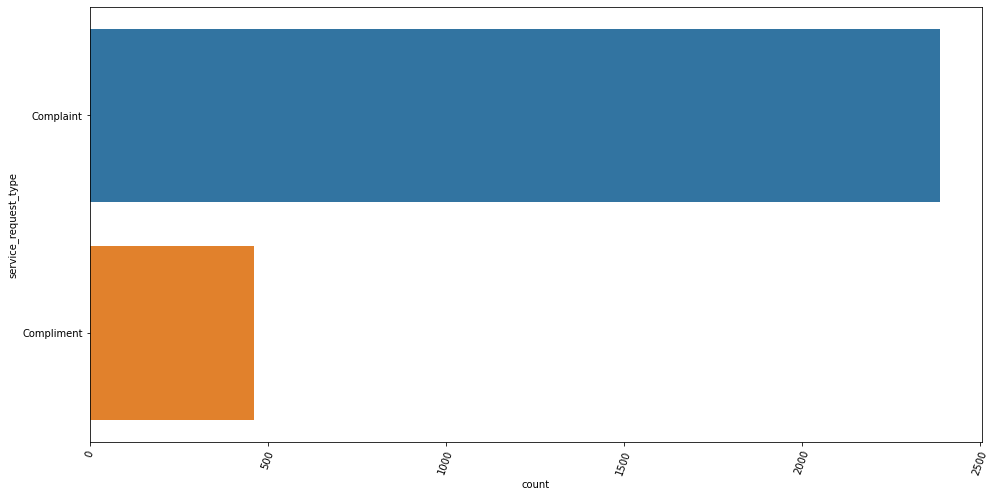

In [39]:
plt.figure(figsize=(16,8))

sns.barplot(y="service_request_type", x="count", data=cs)
plt.xticks(rotation=70)
plt.show()

- Does whether or not its a weekend matter for when a case is opened/closed?

In [18]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



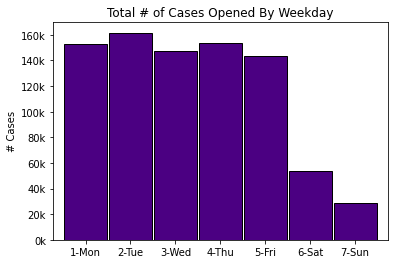

In [46]:
def format_number(x, *args):
    return '{:.0f}k'.format(x / 1000)

(df.withColumn('weekday', date_format('case_opened_date', 'u-E'))
 .groupby('weekday')
 .count()
 .na.drop()
 .toPandas()
 .set_index('weekday')
 ['count']
 .sort_index()
 .plot.bar(width=.95, ec='black', color='indigo')
)
plt.xticks(rotation=0)
plt.gca().set(xlabel='', ylabel='# Cases', title='Total # of Cases Opened By Weekday')
plt.gca().yaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_number))

- On average, how many cases are opened a day for the Customer Service department?

In [47]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



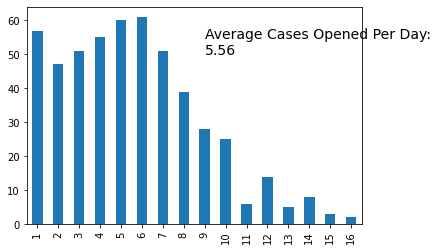

In [48]:
def plot_cases(df):
    s = df['count']
    avg = s.mean()
    s.value_counts().sort_index().plot.bar()
    plt.text(8, 50, f'Average Cases Opened Per Day:\n{avg:.2f}', ha='left', size=14)


(df.withColumn('case_opened_date', expr('date(case_opened_date)'))
 .filter(df.department == 'Customer Service')
 .groupby('case_opened_date')
 .count()
 .toPandas()
 .pipe(plot_cases)
)


- Does the number of service requests for the solid waste department vary by day of the week?

In [49]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
only showing top 1 row



In [58]:
(df.withColumn('weekday', date_format('case_opened_date', 'u-E'))
 .filter(expr('department == "Solid Waste"'))
 .groupby('weekday')
 .count()
 .na.drop()
 .sort(asc("weekday"))
 .show()
)

days = (df.withColumn('weekday', date_format('case_opened_date', 'u-E'))
 .filter(expr('department == "Solid Waste"'))
 .groupby('weekday')
 .count()
 .na.drop()
 .sort(asc("weekday"))
 .toPandas()
)

+-------+-----+
|weekday|count|
+-------+-----+
|  1-Mon|58085|
|  2-Tue|58120|
|  3-Wed|41947|
|  4-Thu|47718|
|  5-Fri|51203|
|  6-Sat|15312|
|  7-Sun| 6882|
+-------+-----+



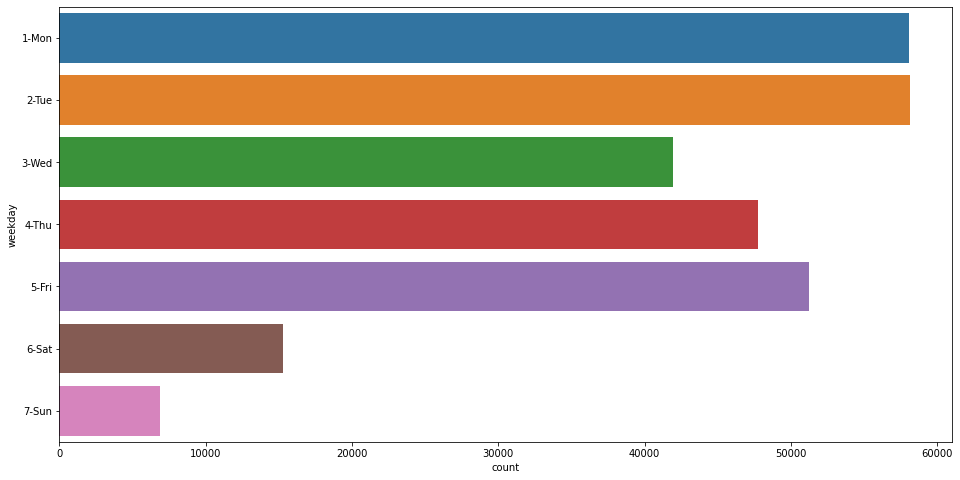

In [60]:
plt.figure(figsize=(16,8))

sns.barplot(y="weekday", x="count", data=days)

plt.show()